In [52]:
%matplotlib inline

In [53]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def process_torch_log(logfname):
    train = {}
    test = {}
    
    import re
    trainp = re.compile('Epoch:\s+\[(\d+)\]\[(\d+)\/(\d+)\]\s+Time\s+(\d+\.\d+)\s+Err\s+(\d+\.\d+)\s+Top1\-\%\:\s+(\d+\.\d+)\s+LR\s+([\d|e|\.\-]+)\s+DataLoadingTime\s+(\d+\.\d+)*')
    testp = re.compile('Epoch:\s+\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)')
    #added top5 accuracy
    testpnew = re.compile('Epoch:\s+\[NEW\]\s*\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)\s+top\-5\s+(\d+\.\d+)')
    
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        iteration_logs = [ trainp.match(l) for l in contents if trainp.match(l)]
        test_logs = [testp.match(l) for l in contents if testp.match(l)]
        testnew_logs = [testpnew.match(l) for l in contents if testpnew.match(l)]
        print len(iteration_logs)," lines of iteration logs to process"
        print len(test_logs)," lines of of test logs to process"
        print len(testnew_logs)," lines of of [NEW] test logs to process"
        it = 0
        epoch = 0
        print "Start Processing Logs... "
        epochSize = 0
        for log in iteration_logs:
            #print log.groups()
            epoch,it,total_iters,time,err,top1,lr,loadt= [eval(n) for n in log.groups()]
            train[epoch] = train.get(epoch, {})
            epochSize = total_iters # should be same for all epochs
            train[epoch][it] = {'err':err,'lr':lr,'top1':top1}
            #train[epoch][1][it] = err
            #train[epoch][2][it] = lr
            #train[epoch][3][it] = top1
        if len(testnew_logs) != 0 :
            for log in testnew_logs:
                epoch,total_time,avg_loss,top1,top5 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['avg_loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = top5
        else:
            if len(test_logs) == 0:
                print "no test logs found!"
            for log in test_logs:
                epoch,total_time,avg_loss,top1 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['avg_loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = 0
        print "Done Log Processing."
        #prepare ndarrays for plotting, conform with caffe analyse result format
        train_tbl = np.zeros((4,len(train.keys()*epochSize))) #iter,trainloss3
        test_tbl = np.zeros((5,len(test.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,len(test.keys())))
        #turn test into nd arrays and sync with caffe result tables
        idx_train = 0
        for epoch,epochData in sorted(train.items()):
            for iter,iterData in sorted(epochData.items()):
                train_tbl[0][idx_train] = (epoch-1)*epochSize + iter # calculate the global iteration
                train_tbl[1][idx_train] = epoch + float(iter)/epochSize
                train_tbl[2][idx_train] = iterData['lr']
                train_tbl[3][idx_train] = iterData['err']
                idx_train = idx_train + 1
        idx_test = 0
        for epoch,epochData in sorted(test.items()):
            test_tbl[0][idx_test] = epoch*epochSize
            test_tbl[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl[2][idx_test] = train[epoch][epochSize]['err'] # trainloss3
            test_tbl[3][idx_test] = epochData['top1']/100.0
            test_tbl[4][idx_test] = epochData['top5']/100.0 #top5
            test_tbl_epoch[0][idx_test] = epoch
            test_tbl_epoch[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl_epoch[2][idx_test] = train[epoch][epochSize]['err'] # ??=trainloss3
            test_tbl_epoch[3][idx_test] = epochData['top1']/100.0
            test_tbl_epoch[4][idx_test] = epochData['top5']/100.0 #top5
            idx_test = idx_test + 1
            #test_tbl[4][idx_test] = epochData['top5']
        #return the train, test results and the last epoch and last iteration
        return train_tbl[:,:idx_train],test_tbl[:,:idx_train],test_tbl_epoch[:,:idx_test],epoch,idx_train

In [55]:
def process_caffe_log(logfname,epoch_size):
    print "processing caffe logs"
    result = {}
    
    import re
    trainiter = re.compile('I(\d\d\d\d\s+\d\d\:\d\d\:\d\d\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+loss\s+=\s+(\d+\.\d+)')
    trainnetloss3 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Train\s+net\s+output\s+#\d\:\s+loss3\/loss\s+=\s+(\d+.\d+)*')
    trainiterlr = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+sgd_solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+lr\s+=\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)')
    testiter = re.compile('I(\d+\s+\d+\:\d+\:\d+.\d+\s+\d+)\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+Testing\s+net\s+\(#0\)')
    testnettop1 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-1\s+=\s+(\d+\.\d+)\s*')
    testnettop5 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-5\s+=\s+(\d+\.\d+)\s*')
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        print "Start Processing Logs..."
        cur_iter = 0
        for log in contents:
            trainiterm = trainiter.match(log)
            trainnetloss3m = trainnetloss3.match(log)
            trainiterlrm = trainiterlr.match(log)
            testiterm = testiter.match(log)
            testnettop1m = testnettop1.match(log)
            testnettop5m = testnettop5.match(log)
            if trainiterm or testiterm:
                #print trainiterm.groups()
                cur_iter = eval(trainiterm.group(2) if trainiterm else testiterm.group(2))
                result[cur_iter] = result.get(cur_iter,{})
                #print "current iteration = ",cur_iter
            elif trainiterlrm :
                result[eval(trainiterlrm.group(2))]['lr'] = eval(trainiterlrm.group(3))
            elif trainnetloss3m:
                result[cur_iter]['trainloss3'] = eval(trainnetloss3m.group(2))
            elif testnettop1m :
                result[cur_iter]['testtop1'] = eval(testnettop1m.group(2))
            elif testnettop5m :
                result[cur_iter]['testtop5'] = eval(testnettop5m.group(2))
            else :
                #print "log doesn't match any of the patterns: ",log
                pass
        print "Done Log Processing."
        
        #prepare ndarrays for plotting
        train_tbl = np.zeros((4,len(result.keys()))) #iter,trainloss3
        test_tbl = np.zeros((5,len(result.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,999))
        #print result
        #get all test results with train lr
        idx_train = 0
        idx_test = 0
        idx_test_epoch = 0
        for iter,values in sorted(result.items()):
            #print iter,values
            if values.has_key('trainloss3'):
                train_tbl[0][idx_train] = iter
                train_tbl[1][idx_train] = float(iter)/epoch_size + 1
                train_tbl[2][idx_train] = values['lr']
                train_tbl[3][idx_train] = values['trainloss3']
                idx_train = idx_train + 1
            if values.has_key('testtop1'):
                #print iter,values
                test_tbl[0][idx_test] = iter
                test_tbl[1][idx_test] = values.get('lr',0)
                test_tbl[2][idx_test] = values.get('trainloss3',0)
                test_tbl[3][idx_test] = values['testtop1']
                test_tbl[4][idx_test] = values['testtop5']
                idx_test = idx_test + 1
                if iter%epoch_size == 0:
                    test_tbl_epoch[0][idx_test_epoch] = int(iter/epoch_size)
                    test_tbl_epoch[1][idx_test_epoch] = values.get('lr',0)
                    test_tbl_epoch[2][idx_test_epoch] = values.get('trainloss3',0)
                    test_tbl_epoch[3][idx_test_epoch] = values['testtop1']
                    test_tbl_epoch[4][idx_test_epoch] = values['testtop5']
                    idx_test_epoch = idx_test_epoch + 1
        print test_tbl_epoch[:,0:idx_test_epoch].shape[1],'epochs with data found'
        #return the errs, top1 accuracy and the last epoch and last iteration
        return train_tbl[:,0:idx_train],test_tbl[:,0:idx_test],test_tbl_epoch[:,0:idx_test_epoch],idx_test_epoch,iter%epoch_size

In [61]:
#process the logs, specify the location of the log file here
result_tbls = []
torch_tests = [
    ('torch-128-original','/home/user/shane/soumith-imgnet-training/torch-yiheng-googlenetv2-bs128-8GPU.log'),
    ('torch-256-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs256-8GPU.log'),
    ('torch-896-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log'),
    #('torch-896-triangular2','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t1.log'),
    ('torch-896-triangular2-hybrid','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t2.log'),
    ]

for (label,log) in torch_tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch,last_epoch,last_it = process_torch_log(log)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch})

caffe_tests = [
    ('caffe-32-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32-1GPU.log',128*10000/32),
    ('caffe-256-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32x8-8GPU.log',128*10000/256),
    ('caffe-512-step','/home/user/shane/caffe/googlenetv2-bs64x8-8GPU.log',128*10000/512),
    ('caffe-512-triangular2','/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2.log',128*10000/512),
    ]
for (label,log,epoch_size) in caffe_tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch,last_epoch,last_it = process_caffe_log(log,epoch_size)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch})
    #print test1[0,:]    

TEST === torch-128-original ===
/home/user/shane/soumith-imgnet-training/torch-yiheng-googlenetv2-bs128-8GPU.log
553767  of log lines to process
550000  lines of iteration logs to process
55  lines of of test logs to process
0  lines of of [NEW] test logs to process
Start Processing Logs... 
Done Log Processing.
TEST === torch-256-original ===
/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs256-8GPU.log
260234  of log lines to process
256622  lines of iteration logs to process
51  lines of of test logs to process
0  lines of of [NEW] test logs to process
Start Processing Logs... 
Done Log Processing.
TEST === torch-896-original ===
/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log
80166  of log lines to process
78650  lines of iteration logs to process
55  lines of of test logs to process
0  lines of of [NEW] test logs to process
Start Processing Logs... 
Done Log Processing.
TEST === torch-896-triangular2-hybrid ===
/home/user/shane/soumith-imgnet-

In [62]:
#### formattings
def plot_formats(num):
    #from itertools import cycle
    #lines = ["-","--"]
    #linecycler = cycle(lines)   
    color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
    if num > len(color_sequence):
        print "not enough color sequence, add more colors"
        return
    lwidths = np.linspace(1,4,num)
    formats = [{'lw':lw,'color':color} for lw,color in zip(lwidths,color_sequence[0:num])]
    return formats

TEST MAX ACCURACY: torch-128-original
maxiter_top1 =  540000.0 top1acc = 0.7095 top5acc = 0.0
maxiter_top5 =  10000.0 top1acc = 0.1848 top5acc = 0.0
total of epochs run: 55
TEST MAX ACCURACY: torch-256-original
maxiter_top1 =  250000.0 top1acc = 0.7008 top5acc = 0.0
maxiter_top5 =  5000.0 top1acc = 0.1614 top5acc = 0.0
total of epochs run: 51
TEST MAX ACCURACY: torch-896-original
maxiter_top1 =  78650.0 top1acc = 0.6802 top5acc = 0.0
maxiter_top5 =  1430.0 top1acc = 0.1186 top5acc = 0.0
total of epochs run: 55
TEST MAX ACCURACY: torch-896-triangular2-hybrid
maxiter_top1 =  44330.0 top1acc = 0.67 top5acc = 0.8754
maxiter_top5 =  44330.0 top1acc = 0.67 top5acc = 0.8754
total of epochs run: 32
TEST MAX ACCURACY: caffe-32-step
maxiter_top1 =  1200000.0 top1acc = 0.712969 top5acc = 0.902656
maxiter_top5 =  1190000.0 top1acc = 0.709594 top5acc = 0.904813
total of epochs run: 124
TEST MAX ACCURACY: caffe-256-step
maxiter_top1 =  1020000.0 top1acc = 0.697875 top5acc = 0.892313
maxiter_top5 =  

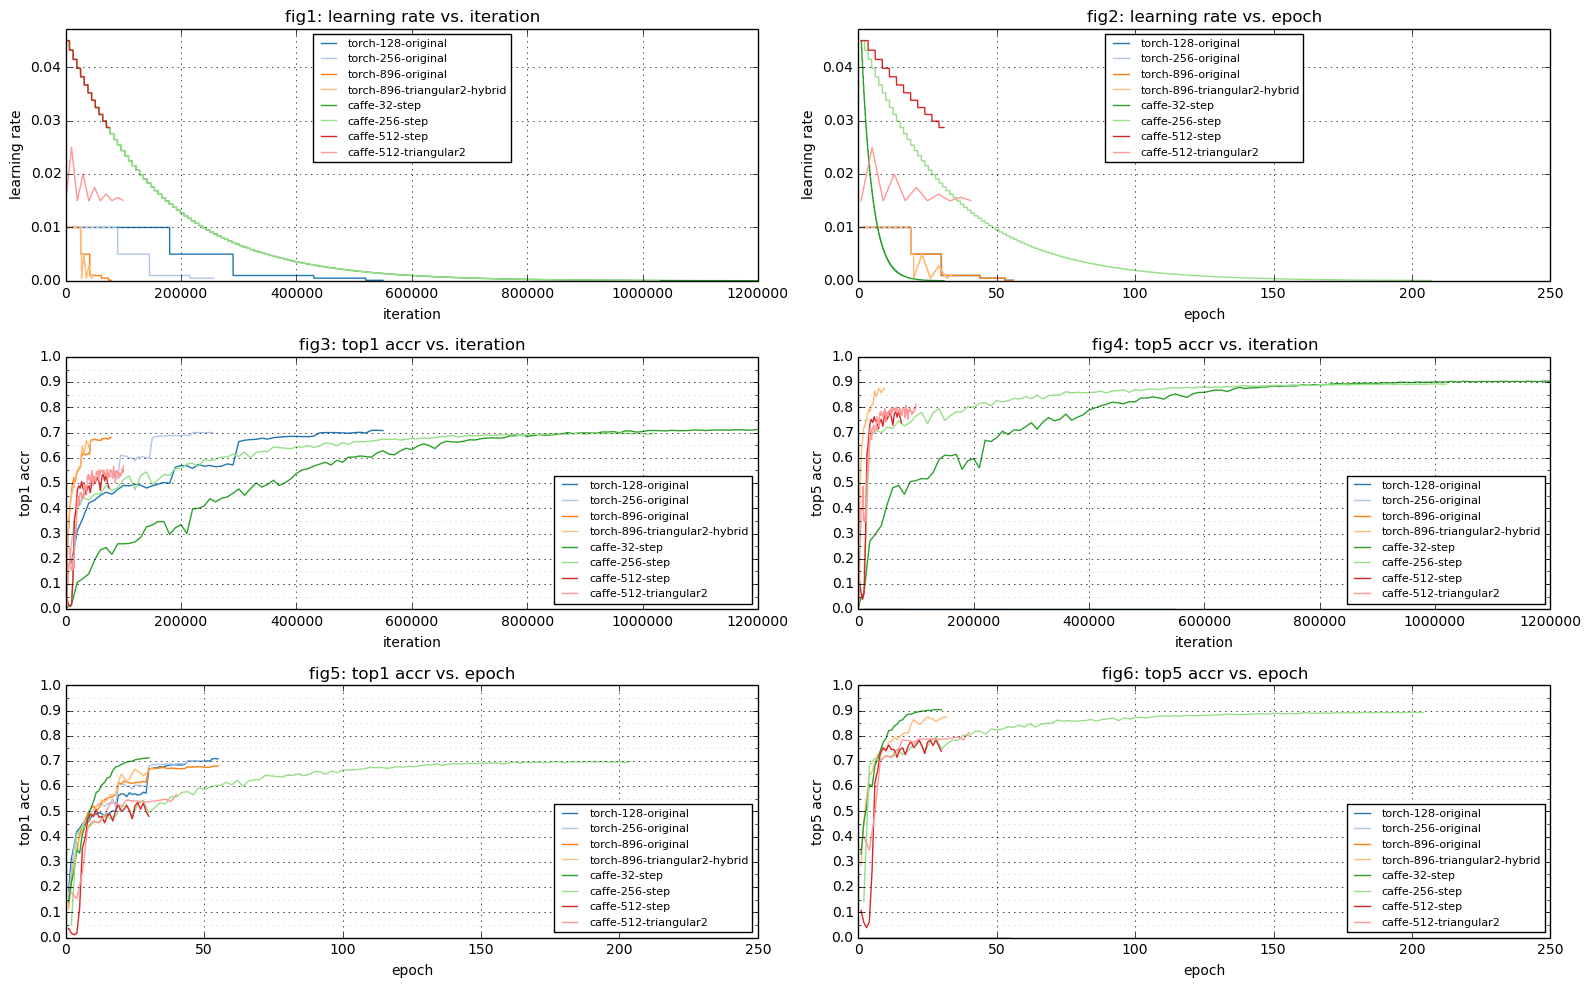

In [63]:
lineformats = plot_formats(len(result_tbls))
#plot the learning curve of one epoch
plt.figure(1,figsize=(16,10))

major_ticks = np.arange(0, 1.01, 0.1)                                              
minor_ticks = np.arange(0, 1.01, 0.05)
#plot the error
ax=plt.subplot(321)
plt.title('fig1: learning rate vs. iteration')
ymax = 0
for result,lineformat in zip(result_tbls,lineformats):
    ymax = max(ymax,max(result['train_result'][2,:]))
    plt.plot(result['train_result'][0,:],result['train_result'][2,:],label=result['label'],color=lineformat['color'])
ax.legend(loc='upper center',fontsize=8)
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('learning rate')
plt.ylim((0,1.05*ymax))

ax=plt.subplot(322)
plt.title('fig2: learning rate vs. epoch')
for result,lineformat in zip(result_tbls,lineformats):
    plt.plot(result['train_result'][1,:],result['train_result'][2,:],label=result['label'],color=lineformat['color'])
ax.legend(loc='upper center',fontsize=8)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('learning rate')      
plt.ylim((0,1.05*ymax))

#plot the accuracies
ax=plt.subplot(323)                                          
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('fig3: top1 accr vs. iteration')
for result,lineformat in zip(result_tbls,lineformats):
    plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'],color=lineformat['color'])
ax.legend(loc='lower right',fontsize=8)
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('iteration')
plt.ylabel('top1 accr')

#plot the accuracies
ax=plt.subplot(324)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('fig4: top5 accr vs. iteration')
for result,lineformat in zip(result_tbls,lineformats):
    plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'],color=lineformat['color'])
ax.legend(loc='lower right',fontsize=8)
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('iteration')
plt.ylabel('top5 accr')
         
#plot the accuracies
ax=plt.subplot(325)                                          
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('fig5: top1 accr vs. epoch')
for result,lineformat in zip(result_tbls,lineformats):
    plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'],color=lineformat['color'])
ax.legend(loc='lower right',fontsize=8)
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('epoch')
plt.ylabel('top1 accr')

#plot the accuracies
ax=plt.subplot(326)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('fig6: top5 accr vs. epoch')
for result,lineformat in zip(result_tbls,lineformats):
    plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'],color=lineformat['color'])
ax.legend(loc='lower right',fontsize=8)
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('epoch')
plt.ylabel('top5 accr')
plt.tight_layout()

for result in result_tbls:
    print 'TEST MAX ACCURACY:',result['label']
    if len(result['test_result'][1]) == 0:
        print "No test log available yet." 
        continue
    am = result['test_result'].max(axis=1)
    maxind = result['test_result'].argmax(axis=1)
    print 'maxiter_top1 = ',result['test_result'][0,maxind[3]],'top1acc =',result['test_result'][3,maxind[3]],'top5acc =',result['test_result'][4,maxind[3]]
    print 'maxiter_top5 = ',result['test_result'][0,maxind[4]],'top1acc =',result['test_result'][3,maxind[4]],'top5acc =',result['test_result'][4,maxind[4]]
    print 'total of epochs run:',result['test_result'].shape[1]